# How to recover a known planet in Kepler data?

We'll try here to recover the planet the signal of Kepler-10b, the first planet discovered by Kepler!

First, we recover the data from the star:

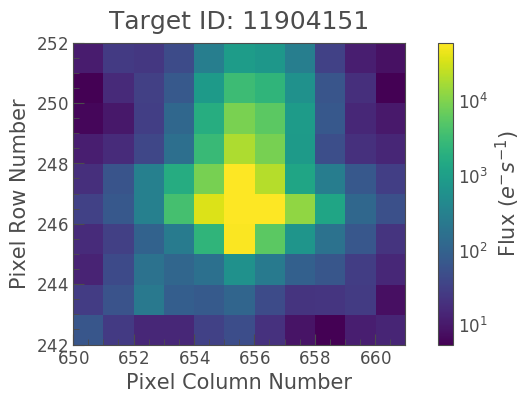

In [19]:
%matplotlib inline
from lightkurve import search_targetpixelfile

tpf = search_targetpixelfile('Kepler-10',quarter=3).download()
tpf.plot(scale='log')

One star is detected.

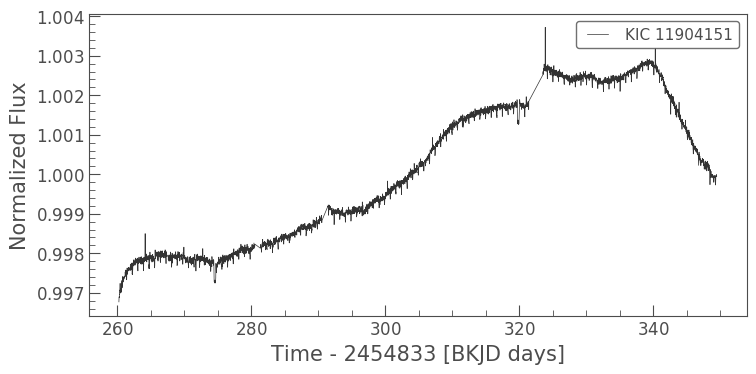

In [2]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

We can flatten the curve with the flat() method, and plot the trend estimated by the Savitzky-Golay filter:

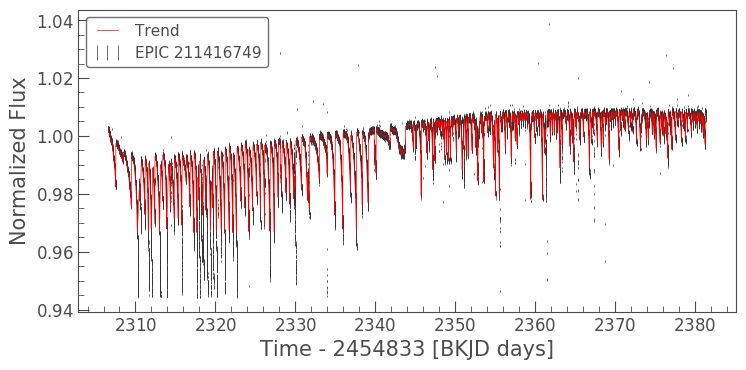

In [22]:
flat, trend = lc.flatten(window_length=301, return_trend=True)
ax = lc.errorbar()                              # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', label='Trend');  # which we can pass to the next plot() to use the same axes

And the flat curve:

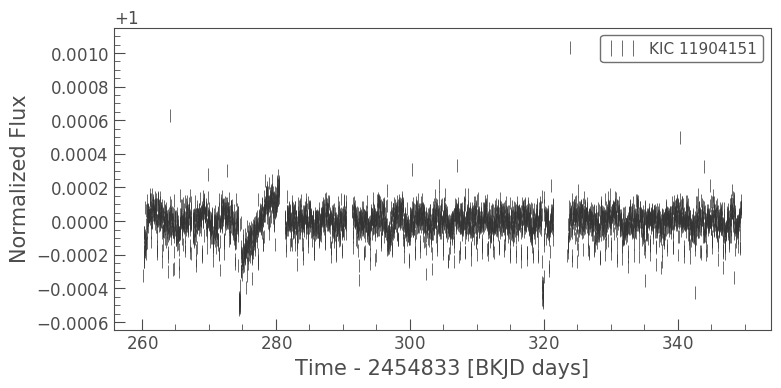

In [4]:
flat.errorbar()

Now, let’s run a period search function using the [Box-Least Squares algorithm](http://docs.astropy.org/en/latest/stats/bls.html), which was added to the AstroPy package in version 3.1.

In [20]:
from astropy import stats

In [23]:
from astropy.stats import BoxLeastSquares

bls = BoxLeastSquares(flat.time, flat.flux, flat.flux_err)

We will use the BLS algorithm to search a pre-defined grid of transit periods and durations:

In [24]:
import numpy as np
periods = np.arange(0.3, 1.5, 0.001)
durations = np.arange(0.005, 0.15, 0.001)
periodogram = bls.power(periods, durations)

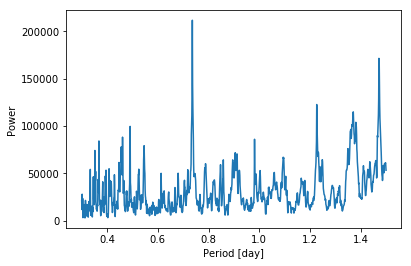

In [25]:
import matplotlib.pyplot as plt
plt.plot(periodogram.period, periodogram.power)
plt.ylabel("Power")
plt.xlabel("Period [day]");

In [9]:
best_fit = periods[np.argmax(periodogram.power)]
print('Best Fit Period: {:0.4f} days'.format(best_fit))

Best Fit Period: 0.8380 days


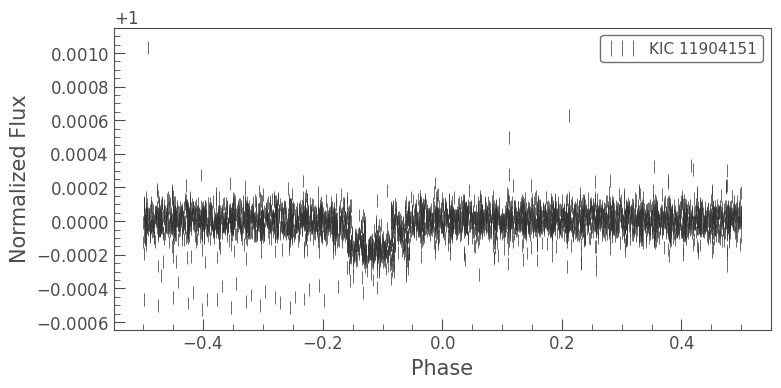

In [10]:
flat.fold(best_fit).errorbar();

We successfully recovered the data of the planet's transit!

# How to recover the first TESS planet candidate with Lightkurve?

Below is a quick tutorial on how to get started using Lightkurve and TESS data. We’ll use the nearby, bright target Pi Mensae (ID 261136679), around which the mission team recently discovered a short period planet candidate on a 6.27 day orbit. See the pre-print paper by Huang et al (2018) for more details.

In [11]:
from lightkurve import TessTargetPixelFile
tpf = TessTargetPixelFile('https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_tp.fits')

TessTargetPixelFile’s have many helpful methods and attributes. For example, you can access basic meta data on the target easily:

In [13]:
tpf.mission, tpf.targetid, tpf.sector, tpf.camera, tpf.ccd

('TESS', 261136679, 1, 4, 2)

We might want to plot the data, we can do this with the plot() method:

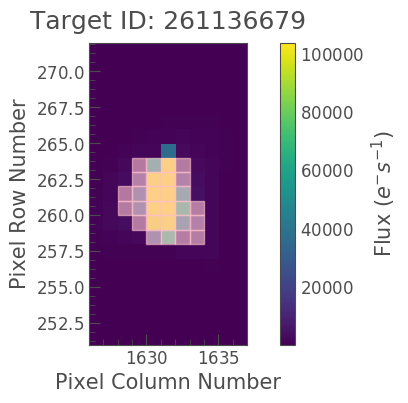

In [14]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

If we want to access the original fits file that generated the data you can use the hdu attribute of the tpf:

In [15]:
tpf.hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001981A6F7A58>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001981A7372B0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000198172E6780>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000019818166BE0>]

The same way as for the Kepler mission, you can access the time and flux with:

In [16]:
tpf.time,tpf.flux, tpf.flux[0]

(array([1325.29698328, 1325.29837215, 1325.29976102, ..., 1353.17292214,
        1353.17431099, 1353.17569985]),
 array([[[  -1.3825388,  -37.66533  ,  -91.830536 , ..., -108.04645  ,
          -103.54175  , -134.1816   ],
         [-135.68407  , -125.30367  , -112.52773  , ..., -113.03839  ,
          -122.92997  , -131.28302  ],
         [-147.63722  , -142.73625  , -134.99854  , ..., -101.330734 ,
          -114.31767  , -121.03055  ],
         ...,
         [-138.13503  , -137.8448   , -146.29425  , ...,  -77.273094 ,
          -105.22347  , -135.82652  ],
         [-142.20255  , -139.6766   , -147.65201  , ..., -118.81814  ,
          -129.52805  , -130.46175  ],
         [-133.71326  , -134.32669  , -148.82013  , ..., -127.16725  ,
           -90.90953  , -112.974434 ]],
 
        [[  -3.390986 ,  -47.140965 ,  -90.53796  , ..., -106.87563  ,
          -108.55464  , -136.6413   ],
         [-133.7175   , -125.38933  , -114.30842  , ..., -115.82087  ,
          -125.8608   , -132.

### Building the light curves from Tess' TPFs

The default for to_lightcurve() is to use the mask generated by the TESS pipeline:

In [18]:
lc = tpf.to_lightcurve()

Now we can plot with error bars:

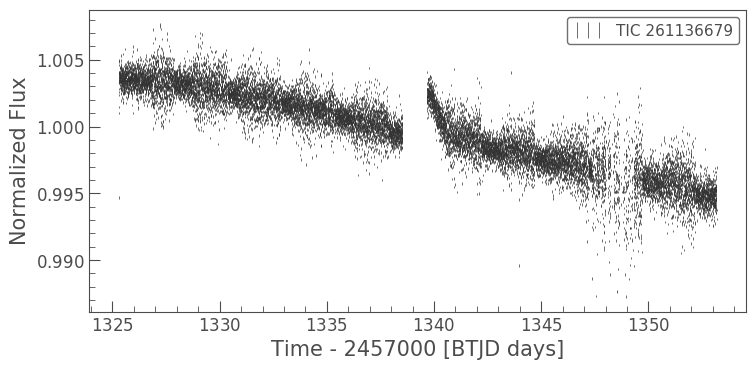

In [19]:
lc.errorbar()

This looks pretty good, but maybe we can improve things by creating a new aperture:

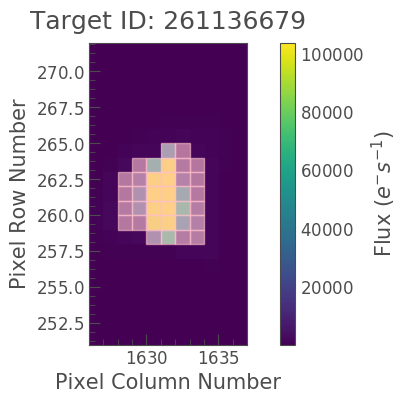

In [26]:
# Create a median image of the source over time
median_image = np.nanmedian(tpf.flux, axis=0)

# Select pixels which are brighter than the 85th percentile of the median image
aperture_mask = median_image > np.nanpercentile(median_image, 85)

# Plot that aperture
tpf.plot(aperture_mask=aperture_mask);

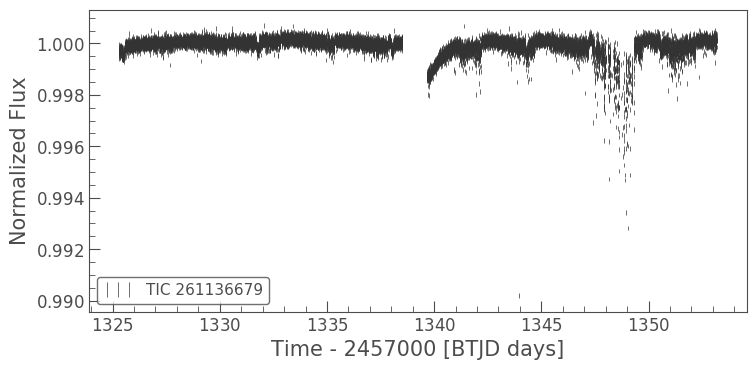

In [27]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.errorbar()

There’s a long term trend in this dataset, which we can remove with a simple smoothing filter. You can use the lc.flatten() method to apply and divide the Savitzky-Golay smoothing filter. Here we’ll use a window_length of 1001 cadences, which is roughly a 5% of the full length of the light curve.

In [28]:
# Number of cadences in the full light curve
print(lc.time.shape)

(18104,)


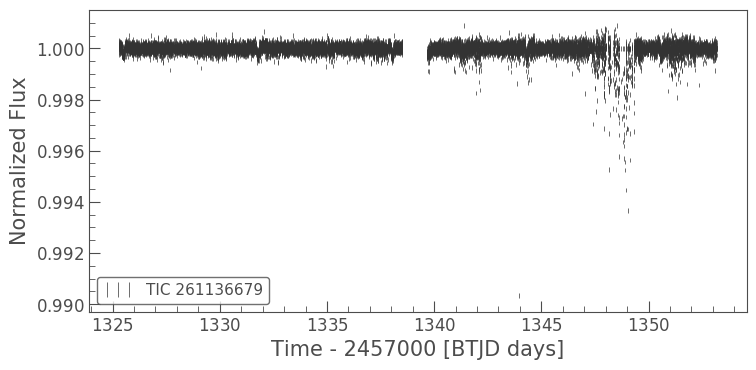

In [29]:
flat_lc = lc.flatten(window_length=1001)
flat_lc.errorbar();

The light curve looks much flatter. Unfortunately there is a portion of the light curve that is very noisy, due to a jitter in the TESS spacecraft. We can remove this simply by masking the light curve. First we’ll select the times that had the jitter.

In [46]:
# Flag the times that are good quality
mask = (flat_lc.time < 1347) | (flat_lc.time > 1350)

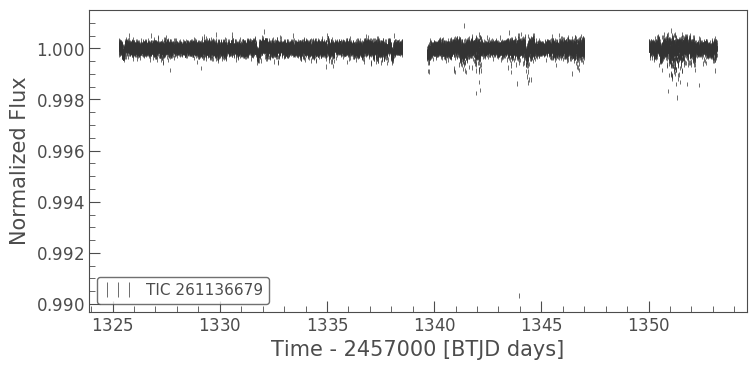

In [47]:
masked_lc = flat_lc[mask]
masked_lc.errorbar();

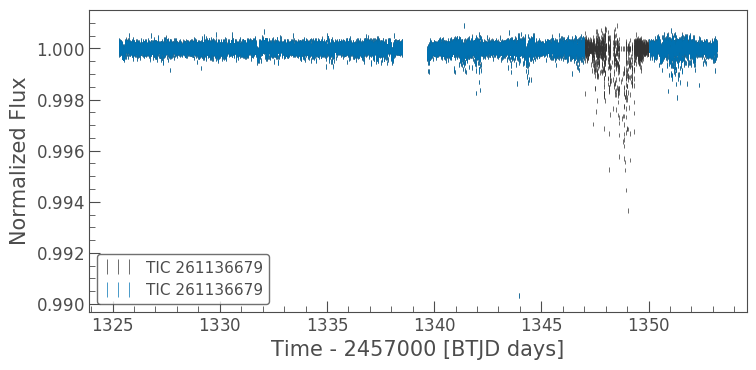

In [48]:
# First define the `matplotlib.pyplot.axes`
ax = flat_lc.errorbar()

# Pass that axis to the next plot
masked_lc.errorbar(ax=ax);

Now we might want to clip out some outliers from the light curve. We can do that with a simple lightkurve function remove_outliers():

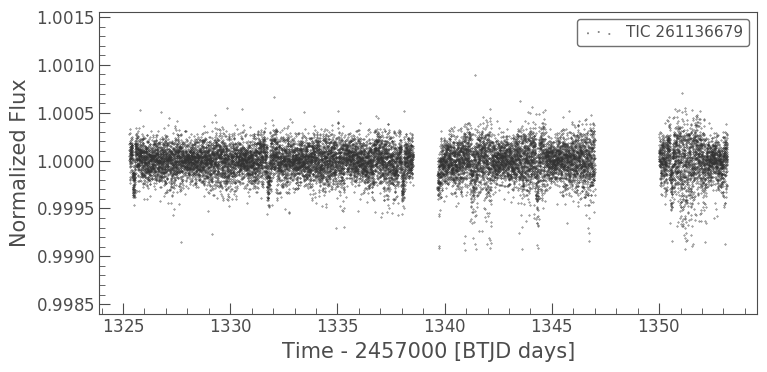

In [49]:
clipped_lc = masked_lc.remove_outliers(sigma=6) #Removes points that are way too far
clipped_lc.scatter(s=0.1); #scatter clears a bit the mess of the error bars

We can add error bars to this:

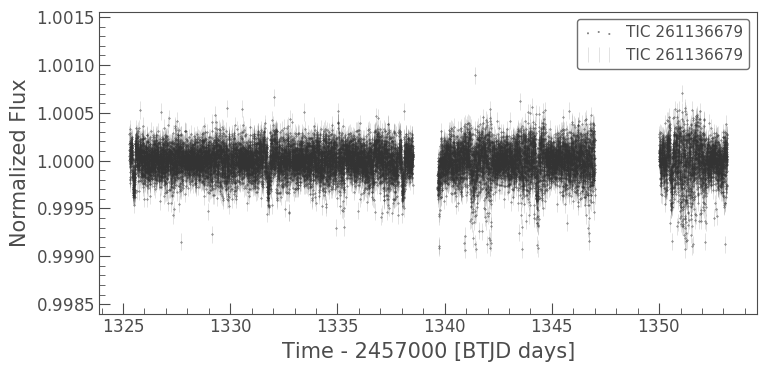

In [50]:
ax = clipped_lc.scatter(s=0.1)
clipped_lc.errorbar(ax=ax, alpha=0.2);  # alpha determines the transparency

Finally let’s use lightkurve to fold the data at the exoplanet orbital period and see if we can see the transit:

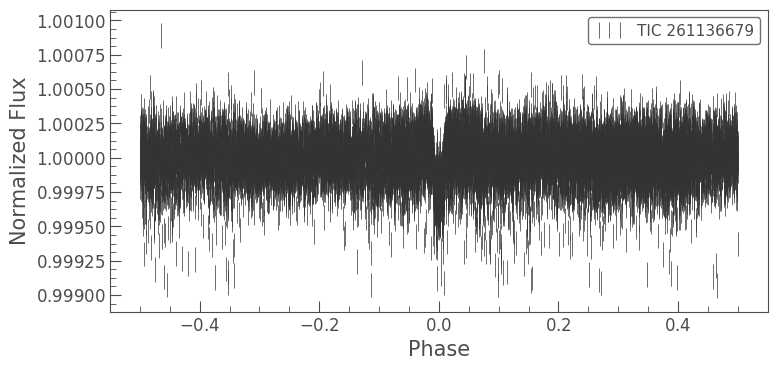

In [56]:
folded_lc = clipped_lc.fold(period=6.27, t0=1325.504) # Where is the period coming from
folded_lc.errorbar();

It looks like there’s something there, but it’s hard to see. Let’s bin the light curve to reduce the number of points, but also reduce the uncertainty of those points:

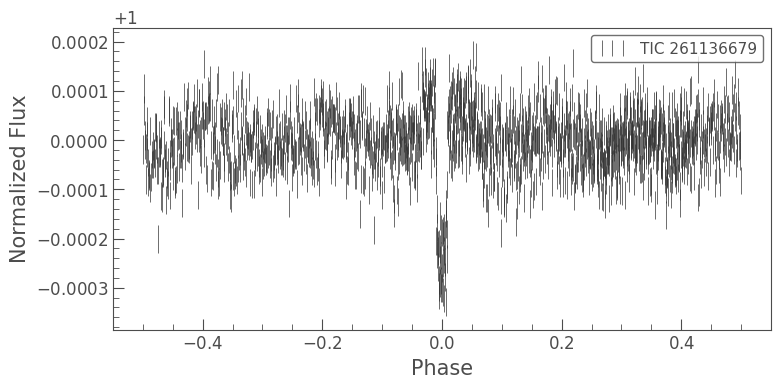

In [52]:
binned_lc = folded_lc.bin(binsize=10)  # Average 10 points per bin
binned_lc.errorbar();

**And now we can see the transit of Pi Men c!**

**Note:** We can do all this in three simple lines:

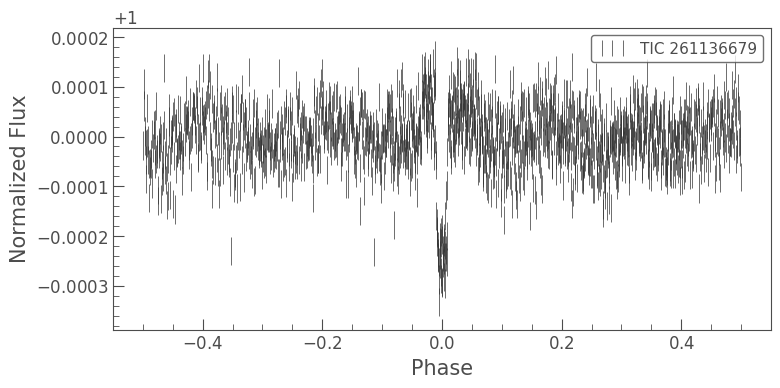

In [54]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask).flatten(window_length=1001) #The aperture was created before
lc = lc[(lc.time < 1346) | (lc.time > 1350)]
lc.remove_outliers(sigma=6).fold(period=6.27, t0=1325.504).bin(binsize=10).errorbar();

### Comparing two apertures

In the above tutorial we used our own aperture instead of the pipeline aperture. Let’s compare the results from using these two different apertures:

In [57]:
# Use the default
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).flatten(window_length=1001)
lc = lc[(lc.time < 1346) | (lc.time > 1350)].remove_outliers(6).fold(period=6.27, t0=1325.504).bin(10)

# Use a custom aperture
custom_lc = tpf.to_lightcurve(aperture_mask=aperture_mask).flatten(window_length=1001)
custom_lc = custom_lc[(custom_lc.time < 1346) | (custom_lc.time > 1350)].remove_outliers(6).fold(period=6.27, t0=1325.504).bin(10)

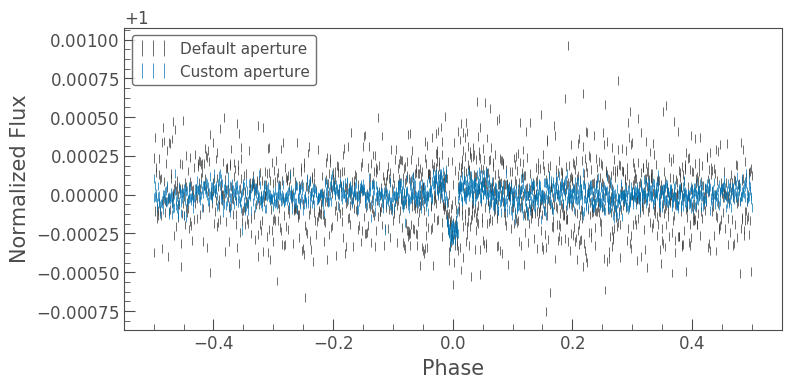

In [59]:
ax = lc.errorbar(label='Default aperture')
custom_lc.errorbar(ax=ax, label='Custom aperture');

The importance of using different aperture masks is clearly visible in the figure above. Note however that the data archive at MAST also contains lightcurve products which have more advanced systematics removal methods applied. We will explore those in a future tutorial!

# How to use lightkurve for asteroseismology

Asteroseisomlogy is the study of stellar oscillations (cepheids, RR Lyraes, etc). To see them, we usually want to transfer from the time domain that light curves are in to the frequency domain. We can do that with methods such as Fourier Transforms or Lomb-Scargle Periodograms. lightkurve has built in methods for working with data in the frequency domain, in the Periodogram class.

Below we demonstrate some of the new functionalities in lightkurve and how to use them for asteroseismology:

In [50]:
from lightkurve import log, search_targetpixelfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import astropy.units as u
log.setLevel('WARNING') # ignore download messages

We'll study the case of a red giant star from campaign 5 (ID=211416749):

In [29]:
ID = 211416749
tpf = search_targetpixelfile(ID, campaign=5, cadence='short').download()

As we are using a short cadence, the data set is much larger, which makes operations longer for some steps.

In [4]:
tpf.flux.shape

(108780, 11, 11)

In [5]:
tpf.plot(scale='log', aperture_mask=tpf.pipeline_mask)

We can use the new **fill_gaps** method to fill in any gaps there are in our data using linear interpolation of the nearest neighbours. This creates an almost perfectly sampled time array with no gaps:

In [6]:
lc = tpf.to_lightcurve()
lc = lc.normalize().remove_nans().remove_outliers().fill_gaps()
lc.plot()

We can now use **lc.periodogram()** to create a periodogram:

In [7]:
p = lc.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=10)

We can plot the power spectrum over the frequencies:

In [8]:
ax = p.plot(c='k')

### Varying the SSF Motion Correction

Unfortunately there is some ringing going on…there is a periodicity in the data due to the K2 motion. We can see below when we plot the data in “Period” space instead of “Frequency” space there is a significant periodicity at ~ 6 hours:

In [9]:
ax = p.plot(c='k', unit=u.hour, view='Period')
ax.text(6, 3e7, '6 hour roll motion')

We can apply our own Self Flat Fielding (SFF) correction to the light curve to remove the K2 roll motion. Below we correct with SFF using the default correct function, with windows=10: (You can read more about SFF in our other tutorials)

In [10]:
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()

C:\Users\pierr\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:1395: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


In [11]:
clc.plot()

Our new, corrected lightcurve looks much flatter and has a much smaller CDPP. Let’s try plotting the periodogram again:

In [12]:
p_clean = clc.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=10)
ax = p_clean.plot(c='k')

Now we zoom on the region of interest:

In [13]:
p_clean = clc.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=100)
ax = p_clean.plot(c='k')

In [14]:
LONG_RUN = False

In [15]:
if LONG_RUN:
    # Loop over several windows ??? What are the windows ???
    for windows in tqdm(np.arange(2, 12, 2)):
        # Create the light curve
        lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
        clc = lc.correct(windows=windows).remove_outliers().fill_gaps()
        # Create the periodogram
        p_clean = clc.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=100)
        # Plot the periodogram
        if windows == 2:
            ax = p_clean.plot(alpha=0.4, label='Windows: {}'.format(windows))
        else:
            p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))

    ax.legend()

### Varying the aperture size

We can also easily change the aperture size. If the aperture is too small, increasing the aperture size should allow us to include more of the target flux. If there is a contaminant nearby, decreasing the aperture may increase our signal to noise.

Below we create a new aperture for the target. In this case we’ve used an aperture where pixels have a value greater than the 70th percentile:

In [17]:
aper = np.nanmedian(tpf.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf.flux, axis=0), 70)

C:\Users\pierr\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\pierr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


We can plot up our new aperture against the pipeline aperture for comparison:

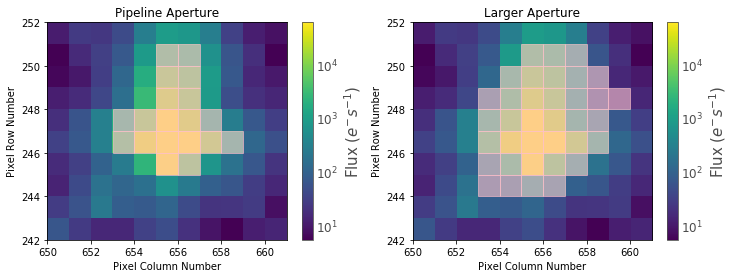

In [26]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=tpf.pipeline_mask)
axs[0].set_title('Pipeline Aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aper)
axs[1].set_title('Larger Aperture');

Now let’s create our two light curves, one with the pipeline aperture and one with the new aperture:

In [30]:
# Create the light curve with the pipelien aperture.
lc_pipeline = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
lc_pipeline = lc_pipeline.to_corrector('sff').correct(windows=10).remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture
lc_larger_aperture = tpf.to_lightcurve(aperture_mask=aper).normalize().remove_nans().remove_outliers()
lc_larger_aperture = lc_larger_aperture.to_corrector('sff').correct(windows=10).remove_outliers().fill_gaps()

When we plot these two light curves we can see that the larger aperture is less noisy:

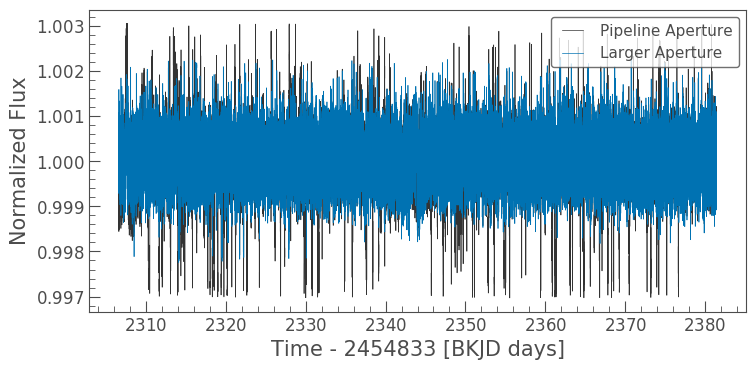

In [35]:
#Plot the pipeline and large aperture light curves
ax = lc_pipeline.plot(label='Pipeline Aperture')
lc_larger_aperture.plot(ax=ax, label='Larger Aperture');

Finally, when we plot the periodogram we can see we’ve increased the signal to noise ratio of our stellar oscillations:

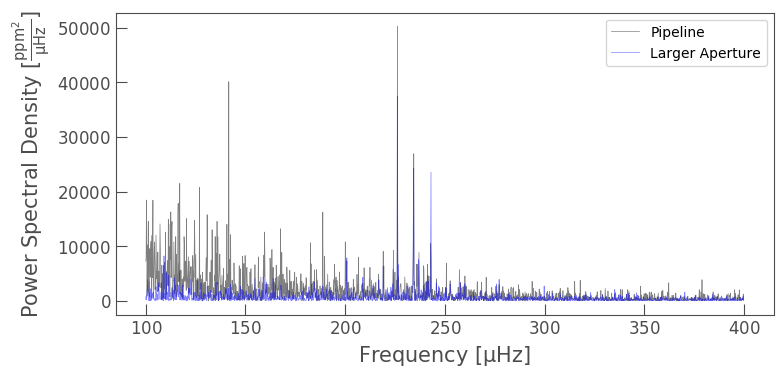

In [63]:
# Create the periodograms
p_pipeline = lc_pipeline.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=100)
p_larger_aperture = lc_larger_aperture.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=100)


# Plot the periodograms
ax = p_pipeline.plot(c='k', alpha=0.5, label='Pipeline')
p_larger_aperture.plot(ax=ax, c='b', alpha=0.5, label='Larger Aperture')

ax.legend();

By increasing our aperture size and including more pixels here we have increased the signal to noise of the oscillation modes of this red giant.

Now, we can try seeing the periodicity:

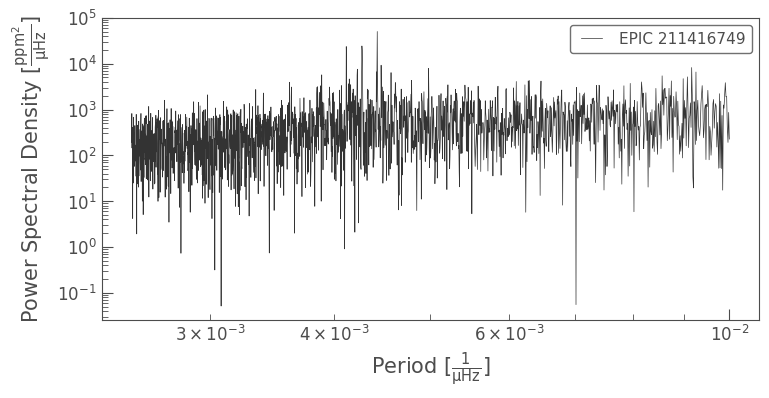

In [65]:
p_larger_aperture.plot(view='period', scale='log')

In [78]:
best_fit = periods[np.argmax(p_larger_aperture.power)]
print('Best Fit Period: {:0.4f} days'.format(best_fit))

Best Fit Period: 1.1160 days


In [72]:
print(lc_larger_aperture.time.shape)

(109890,)


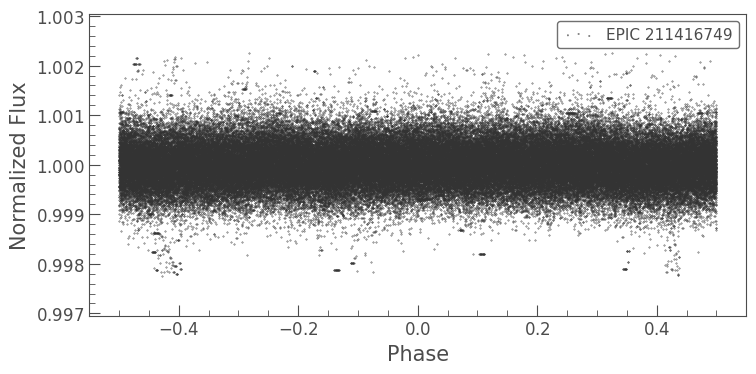

In [73]:
lc_larger_aperture.flatten(window_length=5001)
lc_larger_aperture.fold(best_fit).scatter(s=0.1);

We don't get much to see here, What could we do to make it better?

### Using data from multiple campaigns

Finally, this target was actually observed twice by K2, once in April 2015 in Campaign 5 and once in December 2017 in Campaign 16. We can get both of these data sets and compare the results:

In [81]:
# Download the C16 TPF
tpf_c16 = search_targetpixelfile(ID, campaign=16, cadence='short').download()

# Create a new "large" aperture where flux is greater than the 70th percentile.
aper = np.nanmedian(tpf_c16.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf_c16.flux, axis=0), 70)

# Create a new light curve for C16
lc_c16 = tpf_c16.to_lightcurve(aperture_mask='all').normalize().remove_nans().remove_outliers()
lc_c16 = lc_c16.correct(windows=10).remove_outliers().fill_gaps()

# Create a periodogram for c16 data
p_c16 = lc_c16.to_periodogram(freq_unit=u.microHertz, max_frequency=400, min_frequency=100)

C:\Users\pierr\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\pierr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\Users\pierr\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:1395: LightkurveWarning: `KeplerLightCurve.correct()` is deprecated and will be removed in Lightkurve v1.0.0, please use `LightCurve.to_corrector("sff").correct()` instead.
  LightkurveWarning)


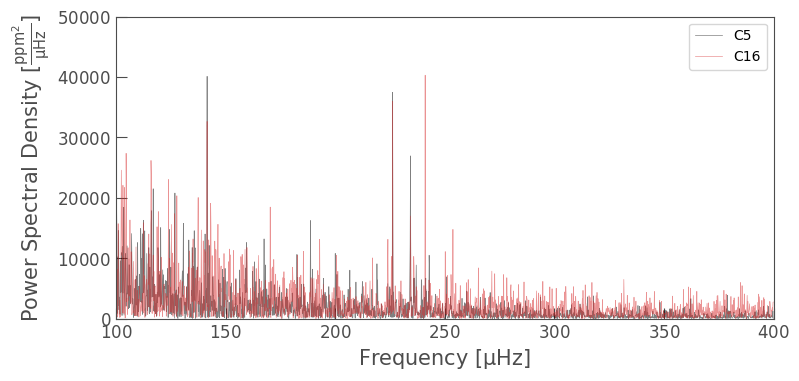

In [82]:
# Create subplots to plot into
ax = p_pipeline.plot(c='k', alpha=0.5, label='C5')
p_c16.plot(ax=ax, c='C3', alpha=0.5, label='C16')

ax.set_xlim(100, 400)
ax.set_ylim(0, 50000)
ax.legend()

**It looks like the two data sets provide similar modes, however the two campaigns have very different instrument systematics. To find the true answer, we should iterate over many different detrending parameters and aperture sizes, and combine datasets to increase signal to noise.**



# How to make a supernova lightcurve?

In this tutorial we will custom-make a custom supernova lightcurve with these simple steps:

1. Create an appropriate aperture mask to isolate the transient from its host galaxy
2. Extract aperture photometry of both the supernova and the background attributable to the host galaxy
3. Apply “Self Flat Fielding” (SFF) detrending techniques
4. Plot the lightcurve

We will focus on an unusual class of transient recently observed in K2, the so-called Fast-Evolving Luminous Transients or FELTs. These transients rise and fall within a mere few days, much shorter than conventional supernovae, which can last hundreds of days. The discovery of KSN2015k was recently reported by Rest et al. 2018 and summarized in at least two press releases from STSci and JPL.

The EPIC ID for KSN2015k’s host galaxy is 212593538:

In [1]:
%matplotlib inline
import numpy as np
from lightkurve import search_targetpixelfile

tpf = search_targetpixelfile(212593538,campaign=6).download()
tpf.shape

(3561, 8, 8)

In [9]:
tpf.path

'C:\\Users\\pierr\\.lightkurve-cache/mastDownload/K2/ktwo212593538-c06_lc/ktwo212593538-c06_lpd-targ.fits.gz'

Thanks to **k2flix ktwo212593538-c06_lpd-targ.fits.gz**, we can animate the plot:

<img src="ktwo212593538-c06_lpd-targ.fits.gz.gif" alt="Target ID: 212593538" title="Target ID: 212593538" />

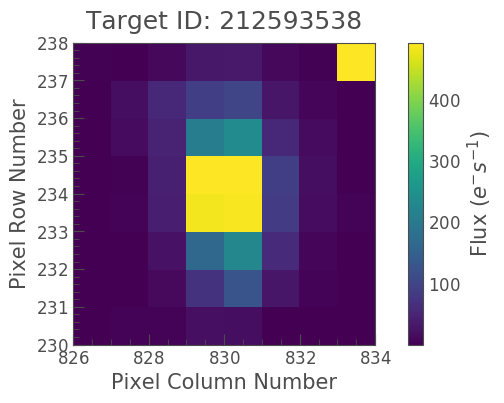

In [2]:
tpf.plot(frame=1000)